# Preamble

## Imports

In [2]:
%matplotlib inline
import networkx as nx
import community
import numpy as np
import matplotlib.pylab as plt
import sys
from collections import Counter, defaultdict
from random import choice
from sklearn.metrics.cluster import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import subprocess
import re
import itertools
import scipy
import random
from random import choice
from ulf import ulf
from functools import wraps
from multiprocessing import Process, Queue, Pool
from scipy.stats import beta
import time
from scipy.interpolate import interp1d

import numpy as np, scipy.stats as st

## Set layout params

In [3]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    fig_width_pt = 417.47*0.6
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

## Utility functions

### General

In [4]:
def NMI_score(p1, p2):
    """Takes two partitions in dict format and returns NMI of partition of common nodes."""
    nodes = sorted(set(p1.keys()) & set(p2.keys()))
    return adjusted_mutual_info_score(
        [p1[n] for n in nodes],
        [p2[n] for n in nodes]
    )

def invert_partition(partition):
    """Transforms between partitions formatted like:
    
        {community: [node, node, node, ...], ...}
                        <-->
        {node: community, node: community, ...}
    """
    if type(partition.items()[0][1]) is list:
        partition_inv = dict()
        for c, nodes in partition.items():
            for n in nodes:
                partition_inv[n] = c
    else:
        partition_inv = defaultdict(list)
        for n, c in partition.items():
            partition_inv[c].append(n)
    return default_to_regular(partition_inv)

def default_to_regular(d):
    """Recursively convert nested defaultdicts to nested dicts.

    Source: http://stackoverflow.com/questions/26496831/how-to-convert-defaultdict-of-defaultdicts-of-defaultdicts-to-dict-of-dicts-o
    """
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d

### Visualization

In [5]:
def draw(G, partition="teal"):
    if partition == True:
        partition = community.best_partition(G).values()
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_nodes(G, pos=pos, node_size=50, alpha=1.0, linewidths=0, node_color=partition)
    nx.draw_networkx_edges(G, pos=pos, width=1, alpha=.3)
    plt.axis("off")
    
def scatter_mean(X, Y, c, label=""):
    plt.plot(
        np.mean(np.array(X), axis=0),
        np.mean(np.array(Y), axis=0),
        c=c, lw=2, ls="--", label=label
    )
    
def confidence_intervals(X, Y, c, label="", mid_50_percentile=False, lw=2, ls="-"):
    X, Y = np.array(X), np.array(Y)
    low, upp = st.t.interval(
        0.99,
        Y.shape[0]-1,
        loc=np.mean(Y, axis=0),
        scale=st.sem(Y)
    )
    plt.fill_between(
        np.mean(X, axis=0),
        low,
        upp,
        alpha=0.5,
        color=c,
        lw=0
    )
    plt.plot(
        np.mean(X, axis=0),
        np.mean(Y, axis=0),
        lw=lw,
        ls=ls,
        c=c,
        label=label
    )
    if mid_50_percentile:
        plt.fill_between(
            np.mean(X, axis=0),
            np.percentile(Y, 25, axis=0),
            np.percentile(Y, 75, axis=0),
            alpha=.25,
            color=c
        )
        
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 100])
    >>> cmap(10)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))

### Networks

In [6]:
# ------------------- #
# Community detection #
# ------------------- #

def Infomap(pajek_string, *args, **kwargs):
    """Function that pipes commands to subprocess and runs native Infomap implementation.
    
    Requires two folders (1) 'input' and (2) 'output', in sister-directory of 'infomap' folder
    that contains 'Infomap' executable. To setup 'infomap' folder, close Infomap from 
    https://github.com/mapequation/infomap and run 'make' inside resulting folder.
    
    Parameters
    ----------
    pajek_string : str
        Pajek representation of the network (str)
    *args : dict
        Infomap execution options. (http://www.mapequation.org/code.html#Options)
    Returns
    -------
    communities : list of lists
    layer_communities : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        def __int_if_int(val):
            try: return int(val)
            except ValueError: return val
        with open('community_detection/input/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), __int_if_int(n.split('"')[1]))
            for n in re.split(r"\*.+", parsed_network)[1].split("\n")[1:-1]
        )
    
    def _parse_communities_multiplex(id_to_label, filename):
        with open('community_detection/output/'+filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu_flow = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu_flow = [tuple(i.split()) for i in la_no_clu_flow]

        node_flow_json = defaultdict(float)      # {layer_node: flow, ...}
        community_flow_json = defaultdict(float) # {community: flow, ...}
        communities_json = defaultdict(set)      # {layer: {(node, cluster), ...}, ...}
        for layer, node, cluster, flow in la_no_clu_flow:
            node_flow_json[(int(layer), id_to_label[int(node)])] += float(flow)
            community_flow_json[cluster] += float(flow)
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json, node_flow_json, community_flow_json
    
    def _parse_communities_planar(id_to_label, filename):
        with open('community_detection/output/'+filename+".clu", 'r') as infile:
            clusters = infile.read()
        
        # Get nodes and clusters from .clu file
        no_clu = [tuple(i.split()[:-1]) for i in re.findall(r"\d+ \d+ \d\.\d+", clusters)]  # [(node, cluster), ...]
        return {0: set([(id_to_label[int(no)], int(clu)) for no, clu in no_clu])}
    
    def _clean_up(filename):
        subprocess.call(['rm', 'community_detection/input/'+filename+'.net'])
        subprocess.call(['rm', 'community_detection/output/'+filename+'_expanded.clu'])
        subprocess.call(['rm', 'community_detection/output/'+filename+'.clu'])
    
    # Check for process id in args (for multiprocessing)
    if args[-1][:3] == "pid":
        pid = args[-1][3:]
        args = args[:-1]
    else:
        pid = ""
        
    # Set default kwarg params
    return_flow = kwargs.get("return_flow", False)
        
    # Get network in multiplex string format and define filename
    filename = 'tmpnet' + pid

    # Store locally
    with open("community_detection/input/"+filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./community_detection/infomap/Infomap', 'community_detection/input/'+filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(filename)
    
    if 'multiplex' in list(args):
        parsed_communities, node_flow, community_flow = _parse_communities_multiplex(id_to_label, filename)
    if 'pajek' in list(args):
        parsed_communities = _parse_communities_planar(id_to_label, filename)
        
    _clean_up(filename)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    layer_communities = {}
    for layer, group in parsed_communities.items():
        communities = {}
        for no, clu in group:
            try:
                communities[clu-1].append(no)
            except KeyError:
                communities[clu-1] = [no]
        layer_communities[layer] = communities

    if return_flow:
        return communities, layer_communities, node_flow, community_flow
    else:
        return communities, layer_communities

# ---------- #
# Formatting #
# ---------- #

def graph_list_to_pajek(G_list):
    """Convert list of graphs to multilayer pajek string
    
    Input
    -----
    G_list : list
        Networkx graphs
    
    Output
    ------
    out : str
        Pajek filestring in *Intra format
    """
    def _write_pajek(A, node_labels=None, index_from=0):
        """Return multiplex representation of multiplex network adjacency matrix A

        Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
        layer k, return a pajek format representation of the temporal network which weights interlayer
        edges by state node neighborhood similarity. 

        Parameters
        ----------
        A : numpy.3darray
            3d tensor where each A[:, :, k] is a layer adjacency matrix
        max_trans_prob : float/str
            Cap on interlayer edge weights. 'square' for square penalty.
        power_penalty : int/float
            Power to jaccard similarity betw. state nodes to penalize low similarity
        index_from : int
            From which number to index nodes and layers in pajek format from
        style : bool
            Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
            essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
            at this point, so 'zigzag' is preferred because it is an explicit representation of the way
            the network should be represented internally in Infomap.

        Returns
        -------
        out_file : string
            A network string in multiplex format
        intid_to_origid : dict
            Key-value pairs of node integer id and original id
        origid_to_intid : dict
            Reverse of intid_to_origid
        """

        def _write_outfile(A):
            """Write nodes and intra/inter-edges from A and J to string."""
            def __remove_symmetry_A(A):
                A_triu = defaultdict(int)
                for (i, j, k), w in A.items():
                    if j > i:
                        A_triu[(i, j, k)] = w
                return A_triu
            def __write_nodes(outfile):
                outfile += "*Vertices %d" % Nn
                for nid, label in enumerate(nodes):
                    outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
                return outfile
            def __write_intra_edges(outfile):
                outfile += "\n*Intra\n# layer node node [weight]"
                for (i, j, k), w in __remove_symmetry_A(A).items():
                    outfile += '\n%d %d %d %f' % (
                        k + index_from,  # layer
                        nodemap[i] + index_from,  # node
                        nodemap[j] + index_from,  # node
                        w                # weight
                    )
                return outfile

            outfile = ""
            outfile = __write_nodes(outfile)
            outfile = __write_intra_edges(outfile)

            return outfile

        nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
        Nn = len(nodes)
        Nl = len(set([k for i, j, k in A.keys()]))

        nodemap = dict(zip(nodes, range(Nn)))

        return _write_outfile(A)

    def _create_adjacency_matrix(layer_edges):
        """Return 3d adjacency matrix of the temporal network.
        
        Input
        -----
        layer_edges : dict
        
        Output
        ------
        A : dict
        """
        A = defaultdict(int)
        for l, edges in layer_edges.items():
            for edge in edges:
                    A[(edge[0], edge[1], l)] += 1
                    A[(edge[1], edge[0], l)] += 1    
        return A
    
    return _write_pajek(
        _create_adjacency_matrix(
            dict(zip(range(len(G_list)), [G.edges() for G in G_list]))
        )
    )


# ------------------ #
# Network generators #
# ------------------ #

def create_planted_partition_graph(l, k, p_in, p_out):
    def _get_shuffle_mapping(G):
        nodes = G.nodes()[:]
        nodes_shuf = G.nodes()[:]; random.shuffle(nodes_shuf)
        return dict(zip(nodes, nodes_shuf))
    G = nx.planted_partition_graph(l, k, p_in, p_out)
    G = nx.relabel_nodes(G, _get_shuffle_mapping(G))
    partition = community.best_partition(G)
    return G, partition

def LFR_benchmark_graph(mu=0.05):
    degree_dist = map(int, np.random.beta(5, 5, 128) * 31 + 1)

    nodes = range(128)
    random.shuffle(nodes)
    commu_nodes = dict((c, nodes[c*32:(c+1)*32]) for c in range(4))
    node_commu = invert_partition(commu_nodes)
    
    degree_sequence = dict(zip(nodes, degree_dist))

    G = nx.MultiGraph()
    G.add_nodes_from(nodes)

    for ni, n in enumerate(sorted(nodes, key=lambda n: degree_sequence[n], reverse=True)):
        num_free_edges = degree_sequence[n] - G.degree(n)
        for e in range(num_free_edges):
            possible_nodes = [pn for pn, d in G.degree().items() if d < degree_sequence[pn] and pn != n]# and pn not in G.neighbors(n)]
            possible_nodes = sorted(possible_nodes, key=lambda pn: degree_sequence[pn] - G.degree(pn), reverse=True)
            if np.random.choice(["intra", "inter"], p=[1-mu, mu]) == "intra":
                try_nodes = [_n for _n in possible_nodes if _n in commu_nodes[node_commu[n]]]
            else:
                try_nodes = [_n for _n in possible_nodes if not _n in commu_nodes[node_commu[n]]]

            if len(try_nodes) == 0:
                quality = (np.mean(G.degree().values()) - np.mean(degree_sequence.values()))
                if quality < -1:
                    LFR_benchmark_graph(mu=mu)
                else:
                    pass
                return G, node_commu
            cn = random.choice(try_nodes)
            G.add_edge(n, cn)
    return G, node_commu


# --------- #
# Operators #
# --------- #

def independent_edge_swaps(G, num_swaps):
    Gc = G.copy()
    for _ in range(num_swaps):
        nx.double_edge_swap(Gc, 1)
    return Gc

def multigraph_to_weighted_graph(M):
    """Convert a nx.MultiGraph into a weighted nx.Graph."""
    G = nx.Graph()
    for u, v, data in M.edges_iter(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G

### Not used (but important for later work)

In [7]:
def multiplex_to_planar(multilayer_network=None):
    
    if multilayer_network is None:
        # Get internal representation of multilayer network from cache
        with open('output/tmpnet.net', 'r') as fp:
            multilayer_network = fp.read()

    # Unwrap nodes and edges
    nodes = set()
    edges = []
    for edge_str in re.split(r"\*.+", multilayer_network)[2].split("\n"):
        
        if len(edge_str) == 0 or edge_str[0] == "#":
            continue

        if edge_str == '':
            print "Fuck!"; break

        if len(edge_str.split()) == 5:
            l1, n1, l2, n2, w = edge_str.split()
        if len(edge_str.split()) == 4:
            l1, n1, n2, w = edge_str.split()
            l2 = l1
            if n1 == "node":
                print n1

        l1n1 = l1 + "_" + n1
        l2n2 = l2 + "_" + n2

        nodes.update([l1n1, l2n2])
        edges.append((l1n1, l2n2, w))

    # Stitch back together as planar network
    name_to_id_map = zip(nodes, range(len(nodes)))
    name_to_id_dict = dict(name_to_id_map)

    planar_network = "*Vertices %d" % len(nodes)
    for node, ni in name_to_id_map:
        planar_network += '\n%d "%s" 1.0' % (ni, node)

    planar_network += "\n*Edges %d" % len(edges)
    for edge in edges:
        planar_network += "\n%d %d %s" % (name_to_id_dict[edge[0]], name_to_id_dict[edge[1]], edge[2])

    return planar_network

def planer_layer_commu_to_multiplex(layer_commu):
    layer_commu = layer_commu[0]
    layer_commu_out = defaultdict(lambda: defaultdict(list))
    for c, state_nodes in layer_commu.items():
        for la_no in state_nodes:
            la, no = map(int, la_no.split("_"))
            layer_commu_out[la][c].append(no)
    return layer_commu_out

def gen_G(network_size=100, K=3, P=1, cut_nodes=15):
    G = nx.powerlaw_cluster_graph(network_size + cut_nodes, K, P)
    for n, k in sorted(G.degree().items(), key=lambda k: k[1], reverse=True)[:cut_nodes]:
        G.remove_node(n)
    for n, k in G.degree().items():
        if k == 0: G.remove_node(n)
            
def interlayer_NMI(layer_commu, signal_layers):
    """Return average NMI between signal_layers and all other layers in layer_commu"""
    layers = sorted(layer_commu.keys())
    partitions = defaultdict(dict)
    for l in layers:
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                partitions[l][int(n)] = c

    similarity = np.zeros((len(layers), len(layers)))
    for l1 in layers:
        partition1 = partitions[l1]
        for l2 in layers:
            partition2 = partitions[l2]
            try:
                similarity[l1, l2] = NMI_score(partition1, partition2)
            except:
                globals().update(locals())
                similarity[l1, l2] = NMI_score(partition1, partition2)
    
    signal_layers = set(signal_layers)
    noise_layers = set(layers) - signal_layers
    
    signal_signal_NMI = np.mean([
        np.mean(similarity[sl, list(signal_layers - {sl})])
        for sl in signal_layers
    ])
    
    signal_noise_mean_NMI = np.mean([
        np.mean(similarity[sl, list(noise_layers)])
        for sl in signal_layers
    ])
    
    signal_noise_std_NMI = np.mean([
        np.std(similarity[sl, list(noise_layers)])
        for sl in signal_layers
    ])
    
    noise_noise_NMI = np.mean([
        np.mean(similarity[nl, list(noise_layers - {nl})])
        for nl in noise_layers
    ])
    
    return signal_signal_NMI, signal_noise_mean_NMI, signal_noise_std_NMI, noise_noise_NMI

# Analysis

## Benchmark A (signal-residual similarity)

In [8]:
def morph_from_G1_to_G2(G, Gt, num_swaps):
    """Exchanges num_swaps edges from G with num_swap edges from Gt"""
    def _dependent_edge_swaps(Gs, Gt):
        
        Gc = Gs.copy()
        
        empty = 0
        done = False
        
        try:
            u, x = choice(list(set(Gc.edges()) - set(Gt.edges())))  # REMOVE random edge not in Gt
            Gc.remove_edge(u, x)
        except IndexError:
            done += 1
        
        try:
            v, y = choice(list(set(Gt.edges()) - set(Gc.edges())))  # ADD random edge not in Gc
            d = Gt.get_edge_data(v, y)
            Gc.add_edge(v, y, d)
        except IndexError:
            done += 1
        
        if done == 2:
            done = True
            
        return Gc, done
    
    def _jaccard_sim(a, b):
        return len(a & b) * 1.0 / len(a | b)
    
    Gs = G.copy()
    
    for _ in range(num_swaps):
        
        Gs, done = _dependent_edge_swaps(Gs, Gt)
        
        if done:
            if _jaccard_sim(set(Gs.edges()), set(Gt.edges())) != 1:
                Gs = Gt
            break
    return Gs

def signal_residual_NMI(layer_commu, L_residual, L_signal):
    """Returns the average NMI between signal and residual layers"""
    def _key_sorted_vals(_dict):
        return list(zip(*sorted(_dict.items(), key=lambda (k, v): k))[1])

    NMI_arr = []
    for Lr in L_residual:
        for Ls in L_signal: 
            NMI_arr.append(NMI_score(
                invert_partition(layer_commu[Lr]),
                invert_partition(layer_commu[Ls])
            ))

    return np.mean(NMI_arr)

def signal_residual_NMI_0_to_lambda(layer_commu, L_residual, L_signal):
    """Returns the average NMI between signal and residual layers"""
    def _key_sorted_vals(_dict):
        return list(zip(*sorted(_dict.items(), key=lambda (k, v): k))[1])

    ps = dict(
        (str(layer) + str(n), c)
        for layer in range(3)
        for n, c in invert_partition(layer_commu[layer]).items()
    )
    pt = dict(
        (str(layer) + str(n), c)
        for layer in range(3)
        for n, c in invert_partition(layer_commu[layer]).items()
    )
    NMI_arr = []
    for Lr in L_residual:
        for Ls in L_signal: 
            NMI_arr.append(NMI_score(
                invert_partition(layer_commu[Lr]),
                invert_partition(layer_commu[Ls])
            ))

    return np.mean(NMI_arr)

def signal_residual_NMI_mod(Gs, Gr_arr):
    """Returns the NMI from modularity between signal and residual layers"""
    NMI = []
    for Gr in Gr_arr:
        NMI.append(
            NMI_score(
                community.best_partition(Gs),
                community.best_partition(Gr)
            )
        )
    return np.mean(NMI)

### Edge exchanges (closed benchmark, [Fig. 3.a])

In [27]:
def worker((N_L_residual, num_c, num_nc, _iter)):
    def _get_random_G(num_c, num_nc):
        return create_planted_partition_graph(num_c, num_nc, 0.95, 0.05/num_c)[0]

    num_e = num_nc * (num_nc - 1) / 2 * num_c
    
    # Signal network
    G = _get_random_G(num_c, num_nc)

    # Residual networks and their independent target networks
    G_residuals = [G for _ in range(N_L_residual)]
    G_targets = [_get_random_G(num_c, num_nc) for l_r in range(N_L_residual)]
    
    # Store residual and signal layer indices
    L_residual = range(1, N_L_residual+1)
    L_signal = [0, N_L_residual+1]

    # Output data
    data = []
    
    # Values to loop over
    swap_vals = range(0, num_e, 10) + [num_e]
    
    prev_n_swaps = 0
    for n_swaps in map(int, swap_vals):

        # Morph residual layers
        G_residuals = [
            morph_from_G1_to_G2(Gr, Gt, (n_swaps - prev_n_swaps))
            for Gr, Gt
            in zip(G_residuals, G_targets)
        ]
        
        # Store number of swaps
        prev_n_swaps = n_swaps
        
        # Make pajek representation of multilayer network
        ml_net = graph_list_to_pajek([G] + G_residuals + [G])

        # Run community detection algorithms
        _, _layer_commu_pred_js = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.15',
            '--markov-time', '1',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_%d' % random.randint(0, 100000000)
        )
        _, _layer_commu_pred_full = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--markov-time', '1',
            '--multiplex-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidfull_%d' % random.randint(0, 100000000)
        )
        _, _layer_commu_pred_adj = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--markov-time', '1',
            '--multiplex-relax-rate', '0.15',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidadj_%d' % random.randint(0, 100000000)
        )
        _, _layer_commu_pred_none = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--markov-time', '1',
            '--multiplex-relax-rate', '0.0',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidnone_%d' % random.randint(0, 100000000)
        )
        
        avg_NMI_js = signal_residual_NMI(_layer_commu_pred_js, L_residual, L_signal)
        avg_NMI_full = signal_residual_NMI(_layer_commu_pred_full, L_residual, L_signal)
        avg_NMI_adj = signal_residual_NMI(_layer_commu_pred_adj, L_residual, L_signal)
        avg_NMI_none = signal_residual_NMI(_layer_commu_pred_none, L_residual, L_signal)
        avg_NMI_mod = signal_residual_NMI_mod(G, G_residuals)
        
        data.append(
            [
                n_swaps / float(num_e),
                avg_NMI_js,
                avg_NMI_full,
                avg_NMI_adj,
                avg_NMI_none,
                avg_NMI_mod
            ]
        )
        
    print "Iter %d done!" % _iter
    return data
    
def simulate_NMI_vs_s(L_residual, num_c, num_nc, niter, parallel=True, args=()):
    
    if args == ():
        XY = []
    else:
        XY = args[0]
        
    data = [(L_residual, num_c, num_nc, _iter) for _iter in range(niter)]
    
    # Run processes in parallel
    if parallel:
        print "\t... Pooling %d processes" % len(data)
        p = Pool(7 if len(data) > 7 else len(data))  # <--- HERE CHANGE 8 TO NUMBER OF AVAIL. PROC.S
        XY.extend(p.map(worker, data))
        p.close()
        
    # Run serially (for debugging)
    if not parallel:
        print "\t... Serializing %d processes" % len(data)
        XY.extend(map(worker, data))
    
    return XY

XY_exchange = simulate_NMI_vs_s(1, 8, 16, 7*5, parallel=True, args=(XY_exchange,))

	... Pooling 35 processes
Iter 4 done!
Iter 10 done!
Iter 12 done!
Iter 8 done!
Iter 0 done!
Iter 2 done!
Iter 6 done!
Iter 13 done!
Iter 5 done!
Iter 9 done!
Iter 1 done!
Iter 3 done!
Iter 11 done!
Iter 7 done!
Iter 14 done!
Iter 20 done!
Iter 22 done!
Iter 18 done!
Iter 16 done!
Iter 24 done!
Iter 26 done!
Iter 17 done!
Iter 25 done!
Iter 23 done!
Iter 15 done!
Iter 21 done!
Iter 19 done!
Iter 27 done!
Iter 32 done!
Iter 30 done!
Iter 28 done!
Iter 34 done!
Iter 29 done!
Iter 33 done!
Iter 31 done!


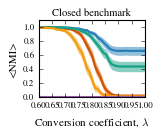

In [28]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

confidence_intervals(np.array(XY_exchange)[:, :, 0], np.array(XY_exchange)[:, :, 1], c="#d35400", label="JSL")
confidence_intervals(np.array(XY_exchange)[:, :, 0], np.array(XY_exchange)[:, :, 2], c="#2980b9", label="FL")
confidence_intervals(np.array(XY_exchange)[:, :, 0], np.array(XY_exchange)[:, :, 3], c="#16a085", label="AL")
confidence_intervals(np.array(XY_exchange)[:, :, 0], np.array(XY_exchange)[:, :, 4], c="#f39c12", label="NL")
confidence_intervals(np.array(XY_exchange)[:, :, 0], np.array(XY_exchange)[:, :, 5], c="#9b59b6", label="Expanded")

plt.title("Closed benchmark")
plt.xlabel("Conversion coefficient, $\lambda$")
plt.ylabel("<NMI>")

plt.ylim(0.0, 1.1)
plt.xlim(0.6,1.0)
plt.savefig("figures/NMI_vs_num_edge_exchanges.pdf")
#plt.legend(loc="lower left", frameon=False)
plt.show()

### Flow isolation (closed benchmark, [Fig. 3.b])

In [ ]:
def worker(_iter):
    
    def _get_random_G():
        return create_planted_partition_graph(8, 16, 0.95, 0.05/8)

    def _community_isolation(node_flow, partition, L_signal):
        community_flow = defaultdict(float)
        for (l, n), flow in node_flow.items():
            if l in L_signal:
                community_flow[partition[n]] += flow
        return community_flow
    
    # Signal network
    Gs, partition_s = _get_random_G()
    Gr = Gs.copy()
    Grt = _get_random_G()[0]

    # Signal/residual layers arrays
    Ls = [0, 2]
    Lr = [1]
    
    # Output data
    x, y_JSL, y_FL, y_AL, y_NL = [], [], [], [], []
    
    prev_n_swaps = 0
    for n_swaps in range(0, 1000, 10):

        # Swappa luppa dubdub!
        Gr = morph_from_G1_to_G2(Gr, Grt, (n_swaps - prev_n_swaps))
        prev_n_swaps = n_swaps

        # Make pajek representation of multilayer network
        ml_net = graph_list_to_pajek([Gs, Gr, Gs])

        _, _, node_flow_JSL, _ = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.99999',
            '--teleportation-probability', '0',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_%d' % random.randint(0, 100000000),
            return_flow=True
        )

        _, _, node_flow_FL, _ = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.99',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_%d' % random.randint(0, 100000000),
            return_flow=True
        )

        _, _, node_flow_AL, _ = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.99',
            '--multiplex-relax-limit', '1',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_%d' % random.randint(0, 100000000),
            return_flow=True
        )

        _, _, node_flow_NL, _ = Infomap(
            ml_net,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.0',
            '--multiplex-relax-limit', '1',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_%d' % random.randint(0, 100000000),
            return_flow=True
        )

        x.append(n_swaps)
        y_JSL.append(sum(_community_isolation(node_flow_JSL, partition_s, Ls).values()))
        y_FL.append(sum(_community_isolation(node_flow_FL, partition_s, Ls).values()))
        y_AL.append(sum(_community_isolation(node_flow_AL, partition_s, Ls).values()))
        y_NL.append(sum(_community_isolation(node_flow_NL, partition_s, Ls).values()))
    
    print "Iter %d done!" % _iter
    return x, y_JSL, y_FL, y_AL, y_NL

def simulate_flow_vs_edge_exchanges(niter, parallel=True, args=()):
    
    if args == ():
        X, Y_JSL, Y_FL, Y_AL, Y_NL = [], [], [], [], []
    else:
        X, Y_JSL, Y_FL, Y_AL, Y_NL = args
        
    data = range(niter)
    
    # Run processes in parallel
    if parallel:
        print "\t... Pooling %d processes" % len(data)
        p = Pool(8 if len(data) > 8 else len(data))
        res = p.map(worker, data)
        p.close()
        
    # Run serially (for debugging)
    if not parallel:
        print "\t... Serializing %d processes" % len(data)
        res = map(worker, data)
    
    # Parse results
    for x, y_JSL, y_FL, y_AL, y_NL in res:
        X.append(x)
        Y_JSL.append(y_JSL)
        Y_FL.append(y_FL)
        Y_AL.append(y_AL)
        Y_NL.append(y_NL)
            
    return X, Y_JSL, Y_FL, Y_AL, Y_NL

X, Y_JSL, Y_FL, Y_AL, Y_NL = simulate_flow_vs_edge_exchanges(8*1, parallel=True)#, args=(X, Y_JSL, Y_FL, Y_AL, Y_NL))

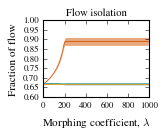

In [377]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

confidence_intervals(X, Y_JSL, c="#d35400", label="JSL", lw=0.75)
confidence_intervals(X, Y_FL, c="#2980b9", label="FL", lw=0.75)
confidence_intervals(X, Y_AL, c="#16a085", label="AL", lw=0.75)
confidence_intervals(X, Y_NL, c="#f39c12", label="NL", lw=0.75)

plt.title("Flow isolation")
plt.xlabel("Morphing coefficient, $\lambda$")
plt.ylabel("Fraction of flow")

plt.ylim(0.6, 1.0)
plt.xlim(0, 1)
plt.savefig("figures/flow_vs_edge_exchanges.pdf")
plt.show()

## Bechmark **B** (sparse network sampling)

In [11]:
# def mean_sample_NMI(layer_commu, G_arr, L, partitions):
#     return np.mean([
#         NMI_score(
#             dict((int(n), c) for n, c in invert_partition(layer_commu[i*L + l]).items()),
#             partitions[i]
#         )
#         for i, _ in enumerate(G_arr)
#         for l in range(L)
#     ])

def mean_sample_NMI(layer_commu, L, partitions):
    multilayer_partition_true = dict()
    multilayer_partition_pred = dict()
    for i in range(len(partitions)):
        for l in range(L):
            layer = i*L + l
            multilayer_partition_true.update(
                dict(
                    (str(layer) + str(n), int(str(i) + str(c)))
                    for n, c in partitions[i].items()
                )
            )
            multilayer_partition_pred.update(
                dict(
                    (str(layer) + str(n), c)
                    for n, c in invert_partition(layer_commu[layer]).items()
                )
            )
    return NMI_score(multilayer_partition_true, multilayer_partition_pred)

# def mean_sample_NMI(layer_commu, G_arr, L, partitions):
#     return NMI_score(
#         dict(
#             (str(i*L + l) + str(n), c)
#             for i, _ in enumerate(G_arr)
#             for l in range(L)
#             for n, c in partitions[i].items()
#         ),
#         dict(
#             (str(i*L + l) + str(n), c)
#             for i, _ in enumerate(G_arr)
#             for l in range(L)
#             for n, c in invert_partition(layer_commu[i*L + l]).items()
#         )
#     )

def shuffle_forward(l):
    order = range(len(l)); random.shuffle(order)
    l_shuf = []
    for j in order:
        l_shuf.append(l[j])
    return l_shuf, order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

def multilayer_network_with_L_samples(G_arr, L, shuf=False):
    def sample_from_graph(G, p):
        G_sample = nx.Graph()
        G_sample.add_nodes_from(G.nodes())
        G_sample.add_edges_from(random.sample(G.edges(), int(p*len(G.edges()))))
        return G_sample
    G_arr_sampled = []
    for G in G_arr:
        for _ in range(L):
            G_arr_sampled.append(sample_from_graph(G, 1.0/L))
        
    if shuf:
        G_arr_sampled, order = shuffle_forward(G_arr_sampled)
        return graph_list_to_pajek(G_arr_sampled), order

    return graph_list_to_pajek(G_arr_sampled)

def reorder_shuffled_layer_commu(lc, order):
    _layer_commu_ordered = dict()
    for i, j in enumerate(order):
        _layer_commu_ordered[j] = lc[i]
    return _layer_commu_ordered

def multilayer_network_with_L_samples_non_iid(G_arr, L):
    """Not used"""
    if L == 1:
        return graph_list_to_pajek(G_arr)
    else:
        G_arr_sampled = []
        for G in G_arr:
            edges = set(G.edges())
            for _ in range(L):
                edges_s = random.sample(edges, int(1.0/L * len(G.edges())))
                edges = edges - set(edges_s)
                Gs = nx.Graph()
                Gs.add_edges_from(edges_s)
                G_arr_sampled.append(Gs)
        return graph_list_to_pajek(G_arr_sampled)

### NMI vs sparsity, *L*, (*T*={1, 3}), [Fig. 4.a-b]

In [40]:
def reorder_shuffled_layer_commu(lc, order):
    _layer_commu_ordered = dict()
    for i, j in enumerate(order):
        _layer_commu_ordered[j] = lc[i]
    return _layer_commu_ordered

def worker(args):
    if len(args) == 2:
        args, order = args
        _, _layer_commu = Infomap(*args)
        _layer_commu = reorder_shuffled_layer_commu(_layer_commu, order)
    else:
        _, _layer_commu = Infomap(*args)
    return _layer_commu, args[-1][3:]

def NMI_vs_L(G_arr, partitions, L_max):
    NMI_js, NMI_full, NMI_adj, NMI_adjshuf, NMI_single = [], [], [], [], []
    L_arr = range(1, L_max+1)
    
    data = []
    
    for L in L_arr:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)
        
        args = [
            pajek_synth,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidfull_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidadj_L%d' % L
        ]
        
        data.append(args)

        args = [(
            pajek_synth_shuf,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.25',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidadjshuf_L%d' % L
        ), order]
        
        data.append(args)

        args = [
            pajek_synth,
            'community_detection/output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.0',
            '--multiplex-relax-limit', '1',
#            '--markov-time', '0.5',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidsingle_L%d' % L
        ]
        
        data.append(args)
    
    p = Pool(7)
    processes = p.map(worker, data)
    
    for output in processes:
        layer_commu, pid = output
        algo = pid.split("_")[0]
        L = int(pid.split("L")[1])
        locals()['NMI_%s' % algo].append(mean_sample_NMI(layer_commu, L, partitions))
        
    p.close()
    
    return NMI_js, NMI_full, NMI_adj, NMI_adjshuf, NMI_single


def run_simulation(T, n_iter, *args):
    
    if args == ():
        js, full, adj, adjshuf, single = [], [], [], [], []
    else:
        js, full, adj, adjshuf, single = args
        
    for i in range(n_iter):
        G_arr, partitions = map(
            list,
            zip(*[LFR_benchmark_graph(mu=0.05) for _ in range(T)])
        )
        NMI_js, NMI_full, NMI_adj, NMI_adjshuf, NMI_single = NMI_vs_L(G_arr, partitions, 12)
        js.append(NMI_js)
        full.append(NMI_full)
        adj.append(NMI_adj)
        adjshuf.append(NMI_adjshuf)
        single.append(NMI_single)
        print i,
        
    return js, full, adj, adjshuf, single

jsT1, fullT1, adjT1, adjshufT1, singleT1 = run_simulation(1, 50)
jsT3, fullT3, adjT3, adjshufT3, singleT3 = run_simulation(3, 50)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


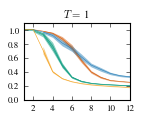

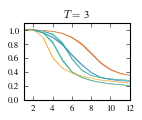

In [42]:
def make121(X, b=2):
    return np.append(np.ones((np.array(X)[:, b:].shape[0], b)), np.array(X)[:, b:], axis=1)
    
for T in [1, 3]:

    L_max = 12
    X = [range(1, L_max+1)]
    
    plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)
    plt.title("$T =$ %d" % T)
    confidence_intervals(X, make121(globals()["jsT%d" % T]), c="#d35400", label="JSC", lw=0.5)
    confidence_intervals(X, make121(globals()["fullT%d" % T]), "#2980b9", label="FC", lw=0.5)
    confidence_intervals(X, make121(globals()["adjT%d" % T]), c="#16a085", label="AC", lw=0.5)
    confidence_intervals(X, make121(globals()["adjshufT%d" % T], 1), c="#16a085", label="AC (unordered layers)", lw=0.5)
    confidence_intervals(X, make121(globals()["singleT%d" % T]), c="#f39c12", label="NC", lw=0.5)

    plt.xlim(1, L_max)
    plt.ylim(0, 1.1)

    #plt.legend(loc="lower left", fontsize=5, frameon=False)
    plt.savefig("figures/NMI_vs_L_where_T_is_%d.pdf" % T)
    

### Performance vs. relax rate, *r* [Fig. 4.d]

In [34]:
def NMI_vs_L(G_arr, partitions, L, scanning_values):
    def _worker(args):
        _, _layer_commu = Infomap(
            *args
        )
        return _layer_commu
    
    NMI_js = []
    
    for relax_rate in scanning_values:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        #pajek_synth, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)  # FOR SHUFFLED
        
        args = [
            pajek_synth,
            'community_detection/output/',
            '-i',
            'multiplex',
            #'--multiplex-relax-rate', str(relax_rate),
            #'--multiplex-relax-rate', '0',
            '--multiplex-js-relax-rate', str(relax_rate),
            #'--multiplex-relax-limit', '1',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_%d' % random.randint(0, 100000000)
        ]
        
        layer_commu = _worker(args)
        #layer_commu = reorder_shuffled_layer_commu(layer_commu, order)  # FOR SHUFFLED
        
        NMI_js.append(mean_sample_NMI(layer_commu, L, partitions))
    
    return NMI_js

def worker((mu, T, L, scanning_values, _iter)):
    #print "\tIteration %d \t ... \t START" % _iter
    G_arr, partitions = map(
        list,
        zip(*[LFR_benchmark_graph(mu=mu) for _ in range(T)])
    )
    
    js = NMI_vs_L(G_arr, partitions, L, scanning_values)
    print "\tIteration %d \t --> \t DONE!" % _iter
    return js

def run_simulation(T, L, n_iter, scanning_values, *args):
    
    print "Running simulation with T = %d, over %d iterations" % (T, n_iter)
    
    if args == ():
        js = []
    else:
        js = args[0]
      
    data = [[0.05, T, L, scanning_values, _iter] for _iter in range(n_iter)]
        
    p = Pool(8)
    js.extend(p.map(worker, data))
    p.close()
    
    return js

scanning_values = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.999]

jsT3L5 = run_simulation(3, 5, 48, scanning_values)
#adjT3L5 = run_simulation(3, 5, 48, scanning_values)
#adjshufT3L5 = run_simulation(3, 5, 48, scanning_values)
#fullT3L5 = run_simulation(3, 5, 48, scanning_values)
#singleT3L5 = run_simulation(3, 5, 48, scanning_values)

Running simulation with T = 3, over 48 iterations
	Iteration 12 	 --> 	 DONE!
	Iteration 0 	 --> 	 DONE!
	Iteration 14 	 --> 	 DONE!
	Iteration 2 	 --> 	 DONE!
	Iteration 6 	 --> 	 DONE!
	Iteration 10 	 --> 	 DONE!
	Iteration 4 	 --> 	 DONE!
	Iteration 8 	 --> 	 DONE!
	Iteration 13 	 --> 	 DONE!
	Iteration 1 	 --> 	 DONE!
	Iteration 15 	 --> 	 DONE!
	Iteration 3 	 --> 	 DONE!
	Iteration 7 	 --> 	 DONE!
	Iteration 11 	 --> 	 DONE!
	Iteration 5 	 --> 	 DONE!
	Iteration 9 	 --> 	 DONE!
	Iteration 16 	 --> 	 DONE!
	Iteration 24 	 --> 	 DONE!
	Iteration 20 	 --> 	 DONE!
	Iteration 18 	 --> 	 DONE!
	Iteration 26 	 --> 	 DONE!
	Iteration 22 	 --> 	 DONE!
	Iteration 30 	 --> 	 DONE!
	Iteration 28 	 --> 	 DONE!
	Iteration 25 	 --> 	 DONE!
	Iteration 17 	 --> 	 DONE!
	Iteration 19 	 --> 	 DONE!
	Iteration 21 	 --> 	 DONE!
	Iteration 27 	 --> 	 DONE!
	Iteration 23 	 --> 	 DONE!
	Iteration 31 	 --> 	 DONE!
	Iteration 29 	 --> 	 DONE!
	Iteration 32 	 --> 	 DONE!
	Iteration 34 	 --> 	 DONE!
	Iterati

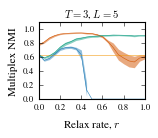

In [48]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)
plt.plot(scanning_values, [np.mean(singleT3L5)]*len(scanning_values), c="#f39c12", lw=0.5)
confidence_intervals([scanning_values], jsT3L5, c="#d35400", label=T, lw=0.5)
confidence_intervals([scanning_values], adjT3L5, c="#16a085", label=T, lw=0.5)
confidence_intervals([scanning_values], fullT3L5, c="#2980b9", label=T, lw=0.5)

plt.xlim(0, 1.0)
plt.ylim(0, 1.1)

plt.title("$T=3$, $L=5$")
plt.xlabel("Relax rate, $r$")
plt.ylabel("Multiplex NMI")

plt.savefig("figures/NMI_vs_relax_rate_T3_L5.pdf")
plt.show()

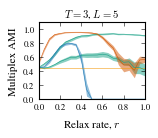

In [37]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)
plt.plot(scanning_values, [np.mean(singleT3L5)]*len(scanning_values), c="#f39c12", lw=0.5)
confidence_intervals([scanning_values], adjT3L5, c="#16a085", label=3, lw=0.5)
confidence_intervals([scanning_values], adjshufT3L5, c="#16a085", label=3, lw=0.5)
confidence_intervals([scanning_values], fullT3L5, c="#2980b9", label=3, lw=0.5)
confidence_intervals([scanning_values], jsT3L5, c="#d35400", label=3, lw=0.5)

plt.xlim(0, 1.0)
plt.ylim(0, 1.1)

plt.title("$T=3$, $L=5$")
plt.xlabel("Relax rate, $r$")
plt.ylabel("Multiplex AMI")

plt.savefig("figures/NMI_vs_relax_rate_T3_L5_adjshufonly.pdf")
plt.show()

### Performance vs number of modes, *T* (*L*=5), [Fig. 4.c]

In [19]:
def worker((T, L)):
    # Create T independent LFR benchmark graphs
    G_arr, partitions = map(
        list,
        zip(*[LFR_benchmark_graph(mu=0.05) for _ in range(T)])
    )

    # Convert to pajek with L samples per state node
    pajek_synth = multilayer_network_with_L_samples(G_arr, L)
    pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)

    # Run infomap
    print "\t    --- Running Infomap (T=%d)" % T
    _, _layer_commu_pred_js = Infomap(
        pajek_synth,
        'community_detection/output/',
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pidjs_%d' % random.randint(0, 100000000)
    )
    _, _layer_commu_pred_full = Infomap(
        pajek_synth,
        'community_detection/output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pidjs_%d' % random.randint(0, 100000000)
    )
    _, _layer_commu_pred_adj = Infomap(
        pajek_synth,
        'community_detection/output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--multiplex-relax-limit', '1'
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pidadj_%d' % random.randint(0, 100000000)
    )
    _, _layer_commu_pred_adjshuf = Infomap(
        pajek_synth_shuf,
        'community_detection/output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--multiplex-relax-limit', '1'
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pidadjshuf_%d' % random.randint(0, 100000000)
    )
    _layer_commu_pred_adjshuf = reorder_shuffled_layer_commu(_layer_commu_pred_adjshuf, order)
    _, _layer_commu_pred_single = Infomap(
        pajek_synth,
        'community_detection/output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.0',
        '--multiplex-relax-limit', '1'
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pidadj_%d' % random.randint(0, 100000000)
    )
    print "\t    --> Infomap done! (T=%d)" % T

    return _layer_commu_pred_js, _layer_commu_pred_full, _layer_commu_pred_adj, _layer_commu_pred_adjshuf, _layer_commu_pred_single, partitions, T, G_arr

def NMI_vs_L(T_arr, L):

    # Prepare input data for _worker
    print "\t... Preparing input data"
    data = [[T, L] for T in sorted(T_arr, reverse=True)]

    # Pool all processes
    print "\t... Pooling %d processes" % len(data)
    p = Pool(7 if len(data) > 7 else len(data))
    res = p.map(worker, data)
    p.close()
    #res = map(_worker, data)
    
    # Extract NMI
    print "\t--> DONE! Extracting data and returning output"
    T_arr_iter, NMI_js_arr_iter, NMI_full_arr_iter, NMI_adj_arr_iter, NMI_adjshuf_arr_iter, NMI_single_arr_iter = [], [], [], [], [], []
    for _layer_commu_pred_js, _layer_commu_pred_full, _layer_commu_pred_adj, _layer_commu_pred_adjshuf, _layer_commu_pred_single, partitions, T, G_arr in sorted(res, key=lambda tup: tup[-2]):
        T_arr_iter.append(T)
        NMI_js_arr_iter.append(mean_sample_NMI(_layer_commu_pred_js, L, partitions))
        NMI_full_arr_iter.append(mean_sample_NMI(_layer_commu_pred_full, L, partitions))
        NMI_adj_arr_iter.append(mean_sample_NMI(_layer_commu_pred_adj, L, partitions))
        NMI_adjshuf_arr_iter.append(mean_sample_NMI(_layer_commu_pred_adjshuf, L, partitions))
        NMI_single_arr_iter.append(mean_sample_NMI(_layer_commu_pred_single, L, partitions))

    return T_arr_iter, NMI_js_arr_iter, NMI_full_arr_iter, NMI_adj_arr_iter, NMI_adjshuf_arr_iter, NMI_single_arr_iter

def run_simulation(T_arr, L, n_iter, *args):
    
    if args == ():
        T_arr_out, js, full, adj, adjshuf, single = [], [], [], [], [], []
    else:
        T_arr_out, js, full, adj, adjshuf, single = args
    
    for i in range(n_iter):
        print "Iteration %d" % (i+1)
        T_arr_iter, NMI_js_arr_iter, NMI_full_arr_iter, NMI_adj_arr_iter, NMI_adjshuf_arr_iter, NMI_single_arr_iter = NMI_vs_L(T_arr, L)
        T_arr_out.append(T_arr_iter)
        js.append(NMI_js_arr_iter)
        full.append(NMI_full_arr_iter)
        adj.append(NMI_adj_arr_iter)
        adjshuf.append(NMI_adjshuf_arr_iter)
        single.append(NMI_single_arr_iter)
            
    return T_arr_out, js, full, adj, adjshuf, single

T_arr = range(1, 10) + range(10, 20, 2) + range(20, 30, 5) + range(30, 60, 10)
T_arr_out, jsL5, fullL5, adjL5, adjshufL5, singleL5 = run_simulation(T_arr, 5, 3, T_arr_out, jsL5, fullL5, adjL5, adjshufL5, singleL5)  # 1 iteration about takes 8m 31s

Iteration 1
	... Preparing input data
	... Pooling 19 processes
	    --- Running Infomap (T=16)
	    --- Running Infomap (T=20)
	    --- Running Infomap (T=18)
	    --- Running Infomap (T=25)
	    --- Running Infomap (T=30)
	    --- Running Infomap (T=40)
	    --> Infomap done! (T=16)
	    --- Running Infomap (T=50)
	    --> Infomap done! (T=18)
	    --> Infomap done! (T=20)
	    --- Running Infomap (T=14)
	    --- Running Infomap (T=12)
	    --- Running Infomap (T=10)
	    --> Infomap done! (T=10)
	    --> Infomap done! (T=12)
	    --> Infomap done! (T=14)
	    --- Running Infomap (T=9)
	    --- Running Infomap (T=7)
	    --- Running Infomap (T=8)
	    --> Infomap done! (T=25)
	    --> Infomap done! (T=7)
	    --> Infomap done! (T=9)
	    --> Infomap done! (T=8)
	    --- Running Infomap (T=6)
	    --- Running Infomap (T=3)
	    --- Running Infomap (T=5)
	    --- Running Infomap (T=4)
	    --> Infomap done! (T=3)
	    --> Infomap done! (T=4)
	    --> Infomap done! (T=5)
	    --- Runnin

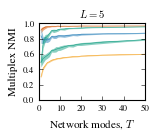

In [21]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)
confidence_intervals(T_arr_out, jsL5, c="#d35400", label="JS", lw=0.5)
confidence_intervals(T_arr_out, fullL5, c="#2980b9", label="Full", lw=0.5)
confidence_intervals(T_arr_out, adjL5, c="#16a085", label="Adjacent", lw=0.5)
confidence_intervals(T_arr_out, adjshufL5, c="#16a085", label="Adjacent", lw=0.5)
confidence_intervals(T_arr_out, singleL5, c="#f39c12", label="None", lw=0.5)

plt.xlim(0, 50)
plt.ylim(0.0, 1)

#plt.yticks([0.7, 0.8, 0.9, 1.0]) 

plt.title("$L=5$")
plt.xlabel("Network modes, $T$")
plt.ylabel("Multiplex NMI")

plt.savefig("figures/NMI_vs_T_L5_r_025.pdf")
plt.show()

$D^{\alpha\beta}_i = 1 - \mathrm{JSD}(P_i^\alpha, P_i^\beta)$